In [1]:
import time
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from torchvision import transforms
import torch
from tqdm import tqdm
from spikingjelly.activation_based import neuron, functional, surrogate , encoding , layer
import math
from numba import jit , prange
from numba.typed import List
import pyspike as spk

In [2]:
# cython language_level=3


# HAVASET BE IN BASHE KE MOMKENE C EMPTY BRAGARDEH VAGHTI N1 SPIKY NADASHTE BASHE


from numba import jit, prange, types
from numba.typed import List
import numpy as np


@jit(nopython=True)
def Interpolate(a, b, t):
    if t < a and a < b:  return a
    if t < b and b <= a: return b
    if t > b:            return b
    return t  # interpolation


@jit(nopython=True)
def get_tau(spikes1, spikes2, i, j, max_tau, MRTS):

    '''


    ## "distances" to neighbor: F/P=future/past, 1/2=N in spikesN.
    mF1 = max_tau
    mP1 = max_tau
    mF2 = max_tau
    mP2 = max_tau

    if i < len(spikes1) - 1 and i > -1:
        mF1 = (spikes1[i + 1] - spikes1[i])
    if j < len(spikes2) - 1 and j > -1:
        mF2 = (spikes2[j + 1] - spikes2[j])
    if i > 0:
        mP1 = (spikes1[i] - spikes1[i - 1])
    if j > 0:
        mP2 = (spikes2[j] - spikes2[j - 1])

    mF1, mF2, mP1, mP2 = mF1 / 2., mF2 / 2., mP1 / 2., mP2 / 2.
    MRTS /= 4.

    if i < 0 or j < 0 or spikes1[i] <= spikes2[j]:
        s1F = Interpolate(mP1, mF1, MRTS)
        s2P = Interpolate(mF2, mP2, MRTS)
        return min(s1F, s2P)
    else:
        s1P = Interpolate(mF1, mP1, MRTS)
        s2F = Interpolate(mP2, mF2, MRTS)
        return min(s1P, s2F)


    '''


    return 0.5




@jit(nopython=True)
def coincidence_single_profile_cython(spikes_times1, spikes_times2, t_start, t_end, max_tau, MRTS=0.):
    
    TotalRegularization = 0

    # spikes1 = ((torch.nonzero(spikestensor1)).view(1, -1)).numpy()[0]
    # spikes2 = ((torch.nonzero(spikestensor2)).view(1,-1)).numpy()[0]

    unsynchroned_times = []

    N1 = len(spikes_times1)
    N2 = len(spikes_times2)

    if N2 == 0:
        spikes_times2 = np.append(spikes_times2, np.array([10000000]))
        N2 = len(spikes_times2)

    j = -1
    c = np.zeros(N1)
    interval = t_end - t_start

    true_max = t_end - t_start
    if max_tau > 0:
        true_max = min(true_max, 2 * max_tau)

    for i in range(N1):

        tau1 = 0
        tau2 = 0

        while j < N2 - 1 and spikes_times2[j + 1] < spikes_times1[i]:
            # move forward until spikes2[j] is the last spike before spikes1[i]
            # note that if spikes2[j] is after spikes1[i] we dont do anything

            j += 1

        tau1 = get_tau(spikes_times1, spikes_times2, i, j, true_max, MRTS)

        if j > -1 and abs(spikes_times1[i] - spikes_times2[
            j]) < tau1:  # حداقل یه اسپایک جی گیر اوردیم و به علاوه یک شده در واقع یه اسپایک به جز اسپایک اول قبل اسپایکمون بوده
            c[i] = 1

        if j < N2 - 1 and (j < 0 or spikes_times2[j] < spikes_times1[i]):

            # in case spikes2[j] is before spikes1[i] it has to be the one
            # right before (see above), hence we move one forward and also
            # check the next spike

            j += 1

            tau2 = get_tau(spikes_times1, spikes_times2, i, j, true_max, MRTS)

            if abs(spikes_times2[j] - spikes_times1[i]) < tau2:
                # current spike in st1 is coincident

                c[i] = 1

        if c[i] == 0:

            # unsynchronized_spikes_data.append([spikes_times1[i] , tau1 , tau2])

            for t in range(int(spikes_times1[i] - tau1 + 1), int(spikes_times1[i] + tau2 + 1)):

                # times.append([t , unsynchronized_spikes_data[i][0] , unsynchronized_spikes_data[i][1] , unsynchronized_spikes_data[i][2]])
                # print(t , unsynchronized_spikes_data[i][0])

                if (t_start <= t <= t_end) and ((spikes_times1[i] > t and abs(spikes_times1[i] - t) < tau1) or (
                        spikes_times1[i] < t and abs(spikes_times1[i] - t) < tau2) or (spikes_times1[i] == t)):
                    unsynchroned_times.append(t)

    return unsynchroned_times  # , unsynchronized_spikes_data

In [3]:
def regularization(spikestensor2, unsynchroned_times):


    if len(unsynchroned_times) != 0:
        # Convert unsynchroned_times to a PyTorch tensor
        unsynchroned_indices = torch.tensor(unsynchroned_times, device=spikestensor2.device, dtype=torch.long)
        # Efficiently select the spikes based on unsynchroned_indices
        selected_spikes = spikestensor2[unsynchroned_indices]
        # Perform the calculation in a vectorized way
        total_regularization = torch.sum((1 - selected_spikes) ** 2)
        # Get elements in A except the elements at indexes in b
        return total_regularization

    else:

        return 0

In [4]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.flatten = layer.Flatten()
        self.fc1 = layer.Linear(28*28, 50, bias=False) # Input
        self.lif1 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())
        self.fc2 = layer.Linear(50, 10, bias=False) # Input
        self.lif2 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())
        

    def forward(self, x: torch.Tensor):

        x = self.flatten(x)
        x = self.lif1(self.fc1(x))
        self.s_layer1 = x
        x = self.lif2(self.fc2(x))
        self.s_layer2 = x
        
        '''
        x = self.lif3(self.fc3(x))
        self.s_layer3 = x
        x = self.lif4(self.fc4(x))
        '''
        
        return x , self.s_layer1 

In [5]:
## Download datasets
train_dataset = torchvision.datasets.MNIST(
    root = "'./data'",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

## DataLoaders
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size = 32,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [6]:
a = torch.randint(0 , 2 , (32 , 50 , 100))

print(a[1:5 , : , :].shape)

torch.Size([4, 50, 100])


In [7]:
def idea(bach, window_size ,fraction , jump):

    number_of_neurons = bach.shape[1]
    T = bach.shape[2]
    window_start = 0
    window_end = window_size
    scroll_jump = jump
    loss = 0

    threshold = fraction*number_of_neurons


    for image_index in range(bach.shape[0]):

        image_spikes = bach[image_index]

        while(window_end <= T - 1):

            selected_window = image_spikes[: , window_start+1 : window_end]

            selected_window_number_of_spikes = torch.sum(selected_window)

            if selected_window_number_of_spikes.item() > threshold :

                loss += torch.sum(torch.square(selected_window))


            window_start += scroll_jump
            window_end += scroll_jump

    return loss
            
            

## training

In [8]:
Numberofspikes_synch = []
trainacc_synch = []
Synchloss_synch = []
last_epoch_record = []
last_epoch_images = []
last_epoch_labels = []
Path = "/Users/manivaziri/Desktop/Models/"



T = 20
momentum = 0.95
epochs = 35
fraction = 0.2

net = SNN()
start_epoch = 0
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
encoder = encoding.PoissonEncoder()


# Training
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    synch_loss = 0
    number_of_spikes = 0

    

    for img, label in train_data_loader:
        optimizer.zero_grad()
        img = img
        label = label
        label_onehot = F.one_hot(label, 10).float()
        
        out_fr = 0

        loss_synch_layer1 = 0


        #bach_records = [] # array of shape [*NumberOfLayers[(tensors , ... of shape (batchImageNumbers*Time) which represent every neuron in layer)]]
        
        for t in range(T):
            
            encoded_img = encoder(img)
            out , layers_spikes  = net(encoded_img)
            #, layers_spikes2 , layers_spikes3 
            out_fr += out


            layers_spikes1 = layers_spikes.unsqueeze(2)


            
            '''
            layers_spikes2 = layers_spikes2.unsqueeze(2)
            layers_spikes3 = layers_spikes3.unsqueeze(2)
            '''
            


            if t == 0 :

                slayer1 = layers_spikes1
                '''
                slayer2 = layers_spikes2
                slayer3 = layers_spikes3
                '''

            else :

                slayer1 = torch.cat((slayer1, layers_spikes1), dim=2)
                '''
                slayer2 = torch.cat((slayer2, layers_spikes2), dim=2)
                slayer3 =  torch.cat((slayer3, layers_spikes3), dim=2)
                '''

                
            

        if epoch == epochs - 1:

            last_epoch_record.append(slayer1)
            last_epoch_images.append(img)
            last_epoch_labels.append(label)
            
        

        number_of_spikes += torch.sum(slayer1).item()
        
        out_fr = out_fr/T

        loss_synch_layer1 = idea(slayer1 , 5 , 0.2 , 2)
        
        loss = F.mse_loss(out_fr, label_onehot) + (10**-5)*loss_synch_layer1
        loss.backward()
        optimizer.step()


        synch_loss += loss_synch_layer1


        
        train_samples += label.numel() # number of elemets
        train_loss += loss.item()*label.numel()
        # The correct rate is calculated as follows:
        # The subscript i of the neuron with the highest firing rate in the output layer
        # is considered as the result of classification.
        train_acc += (out_fr.argmax(1)==label).float().sum().item()

        # After optimizing the parameters, the state of the network should be reset
        # because the neurons of the SNN have “memory”.
        functional.reset_net(net)
        


    torch.save(net.state_dict(), Path + f"model{epoch}.pt")
    
    train_time = time.time() 
    train_speed = train_samples/(train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples
    Numberofspikes_synch.append(number_of_spikes)
    trainacc_synch.append(train_acc)
    Synchloss_synch.append(synch_loss)
    print(f"train_acc : {train_acc} | " , f"Synch Loss for epoch!: {synch_loss} | " , f"number of spikes : {number_of_spikes} | " , f"train_loss : {train_loss} | " , f"time lenght :{train_time - start_time}")



train_acc : 0.8873166666666666 |  Synch Loss for epoch!: 821376.0 |  number of spikes : 16311595.0 |  train_loss : 0.026348971779892844 |  time lenght :35.19271230697632
train_acc : 0.94385 |  Synch Loss for epoch!: 612483.0 |  number of spikes : 12172253.0 |  train_loss : 0.014136100850254298 |  time lenght :34.587018966674805
train_acc : 0.9554666666666667 |  Synch Loss for epoch!: 505434.0 |  number of spikes : 9932855.0 |  train_loss : 0.0113918104223907 |  time lenght :35.54174304008484
train_acc : 0.9626666666666667 |  Synch Loss for epoch!: 443645.0 |  number of spikes : 8759550.0 |  train_loss : 0.009825531589736541 |  time lenght :35.68667197227478
train_acc : 0.96685 |  Synch Loss for epoch!: 410718.0 |  number of spikes : 8121255.0 |  train_loss : 0.008833325096033514 |  time lenght :37.572043895721436
train_acc : 0.97045 |  Synch Loss for epoch!: 381699.0 |  number of spikes : 7588618.0 |  train_loss : 0.00804490711428225 |  time lenght :38.0698926448822
train_acc : 0.97331

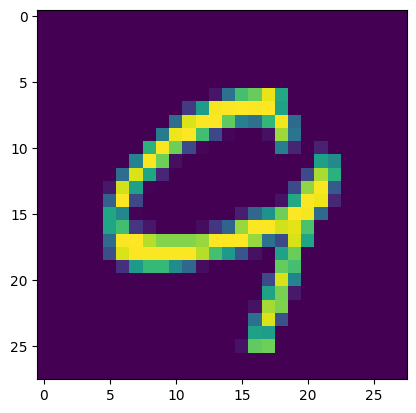

In [9]:
a = last_epoch_images[1][30]
plt.imshow(a.view(28 , 28).numpy())
plt.show()

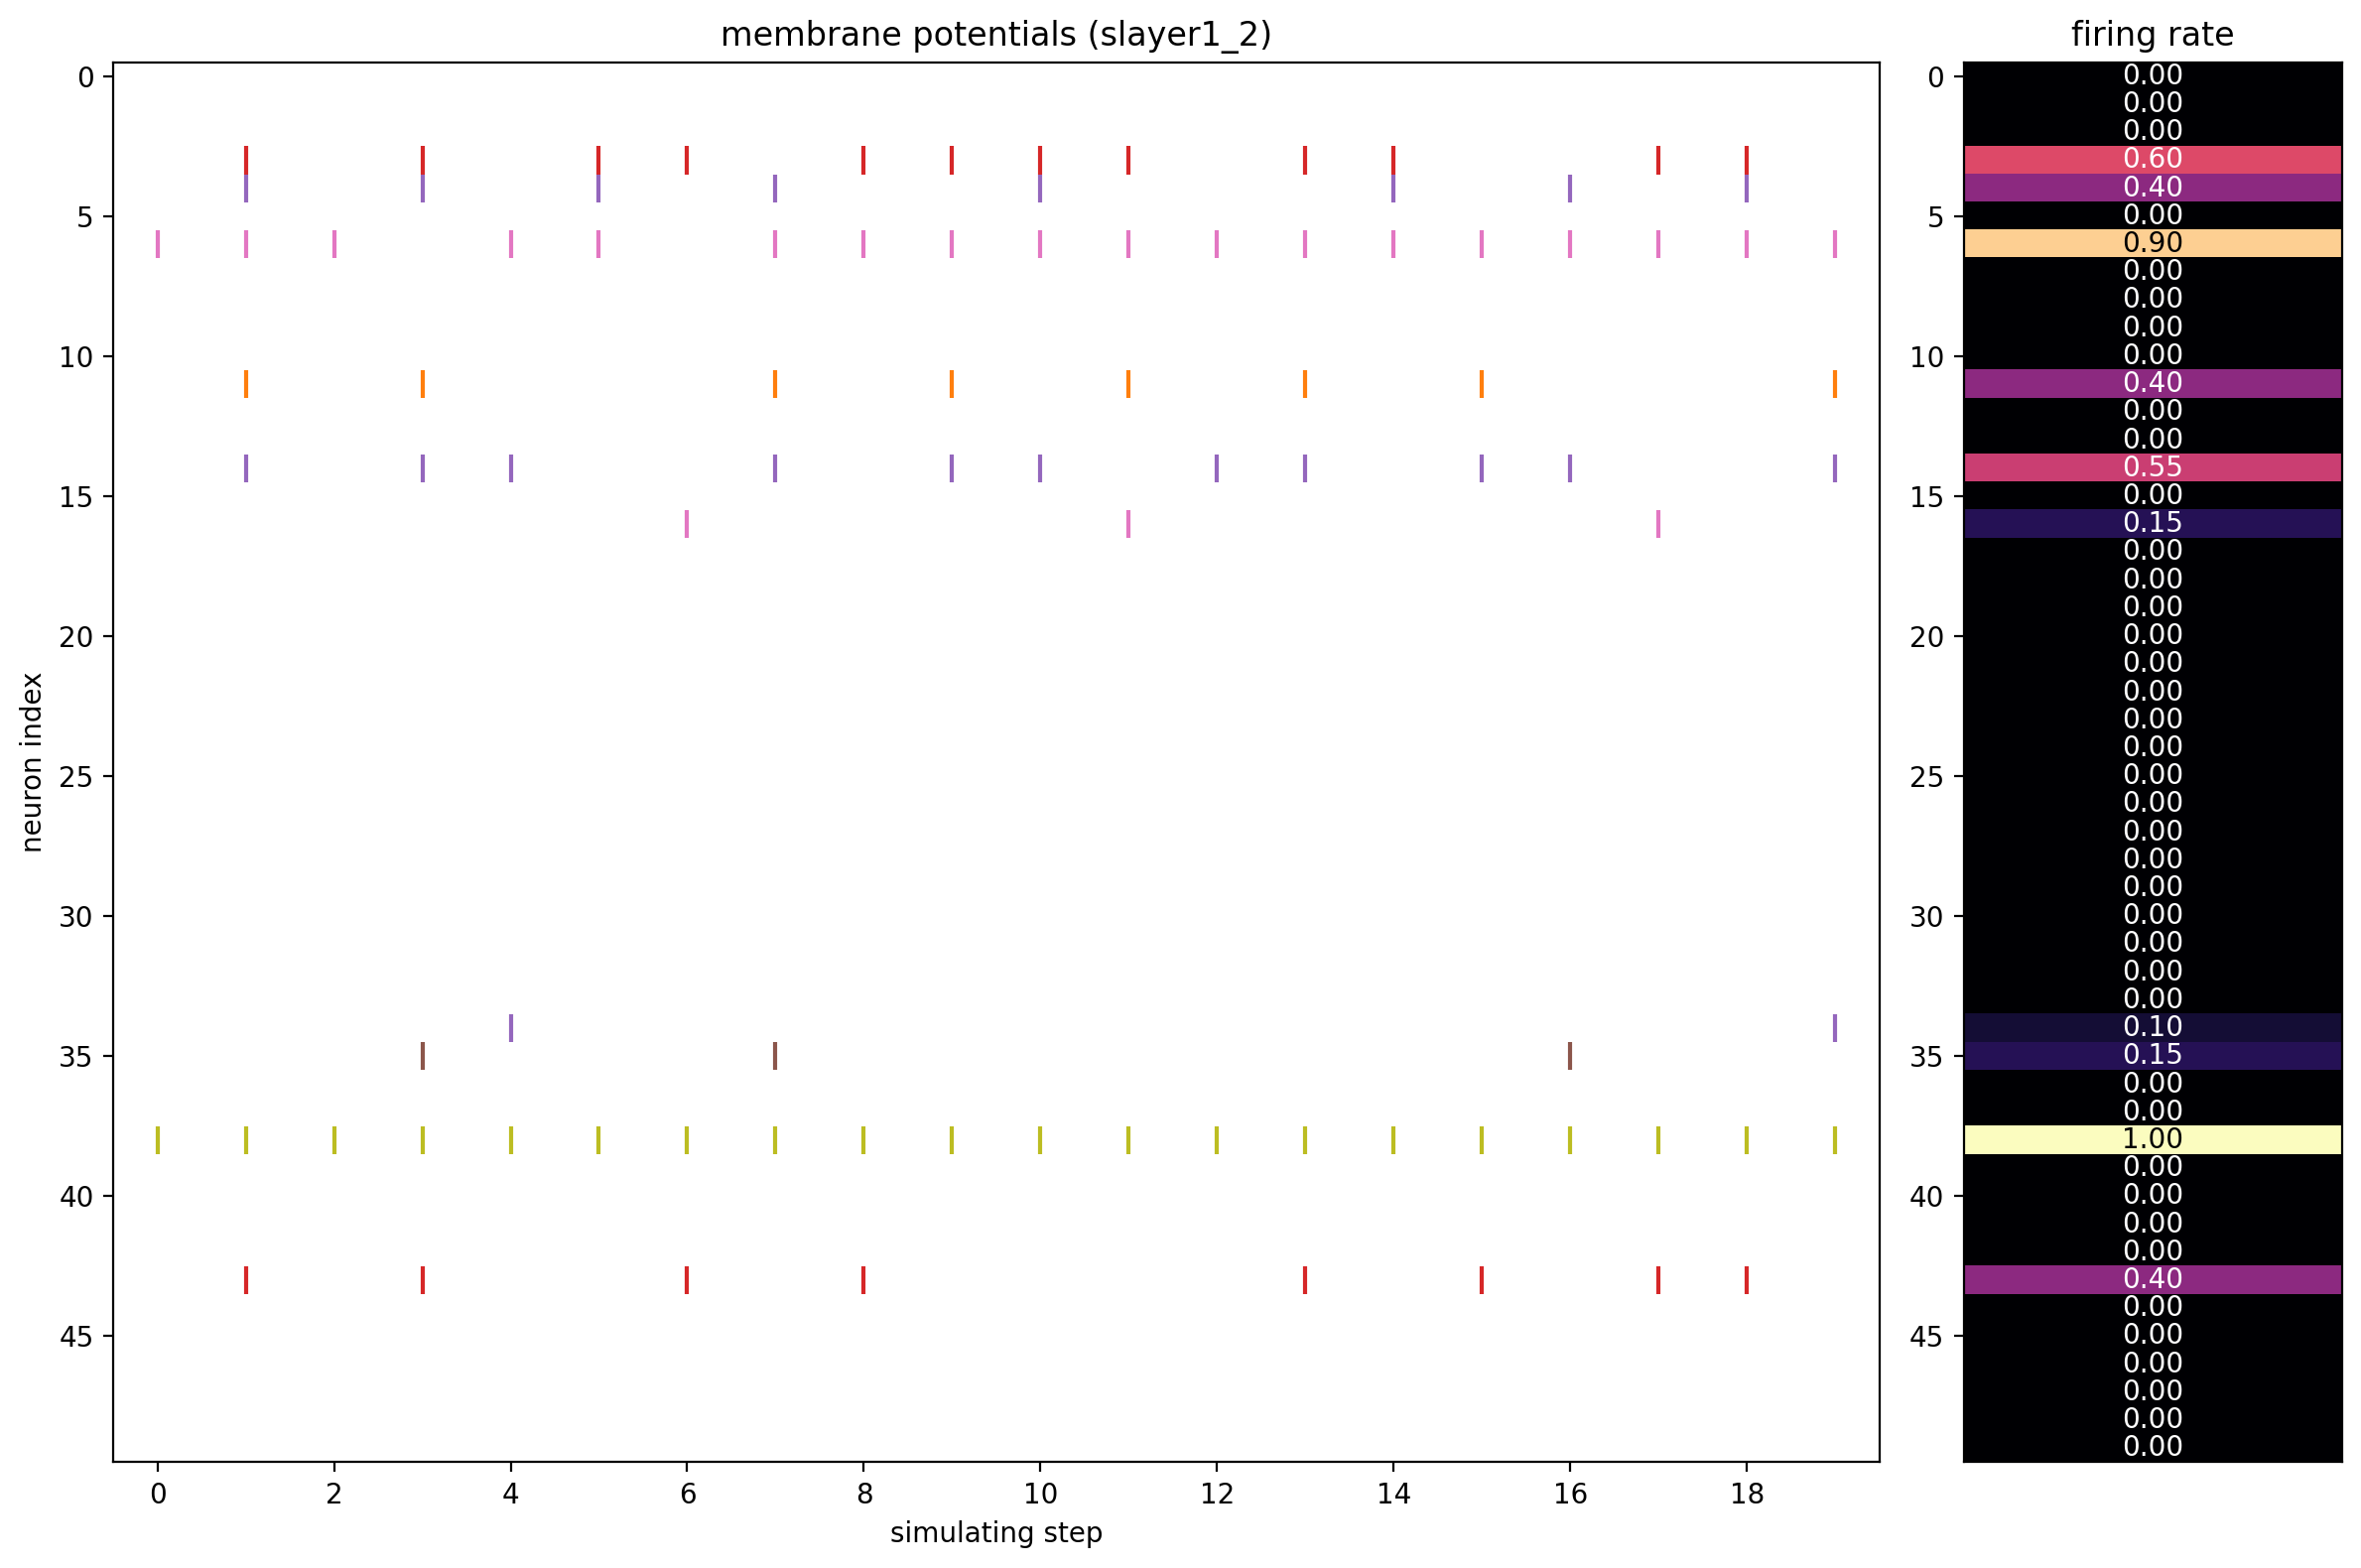

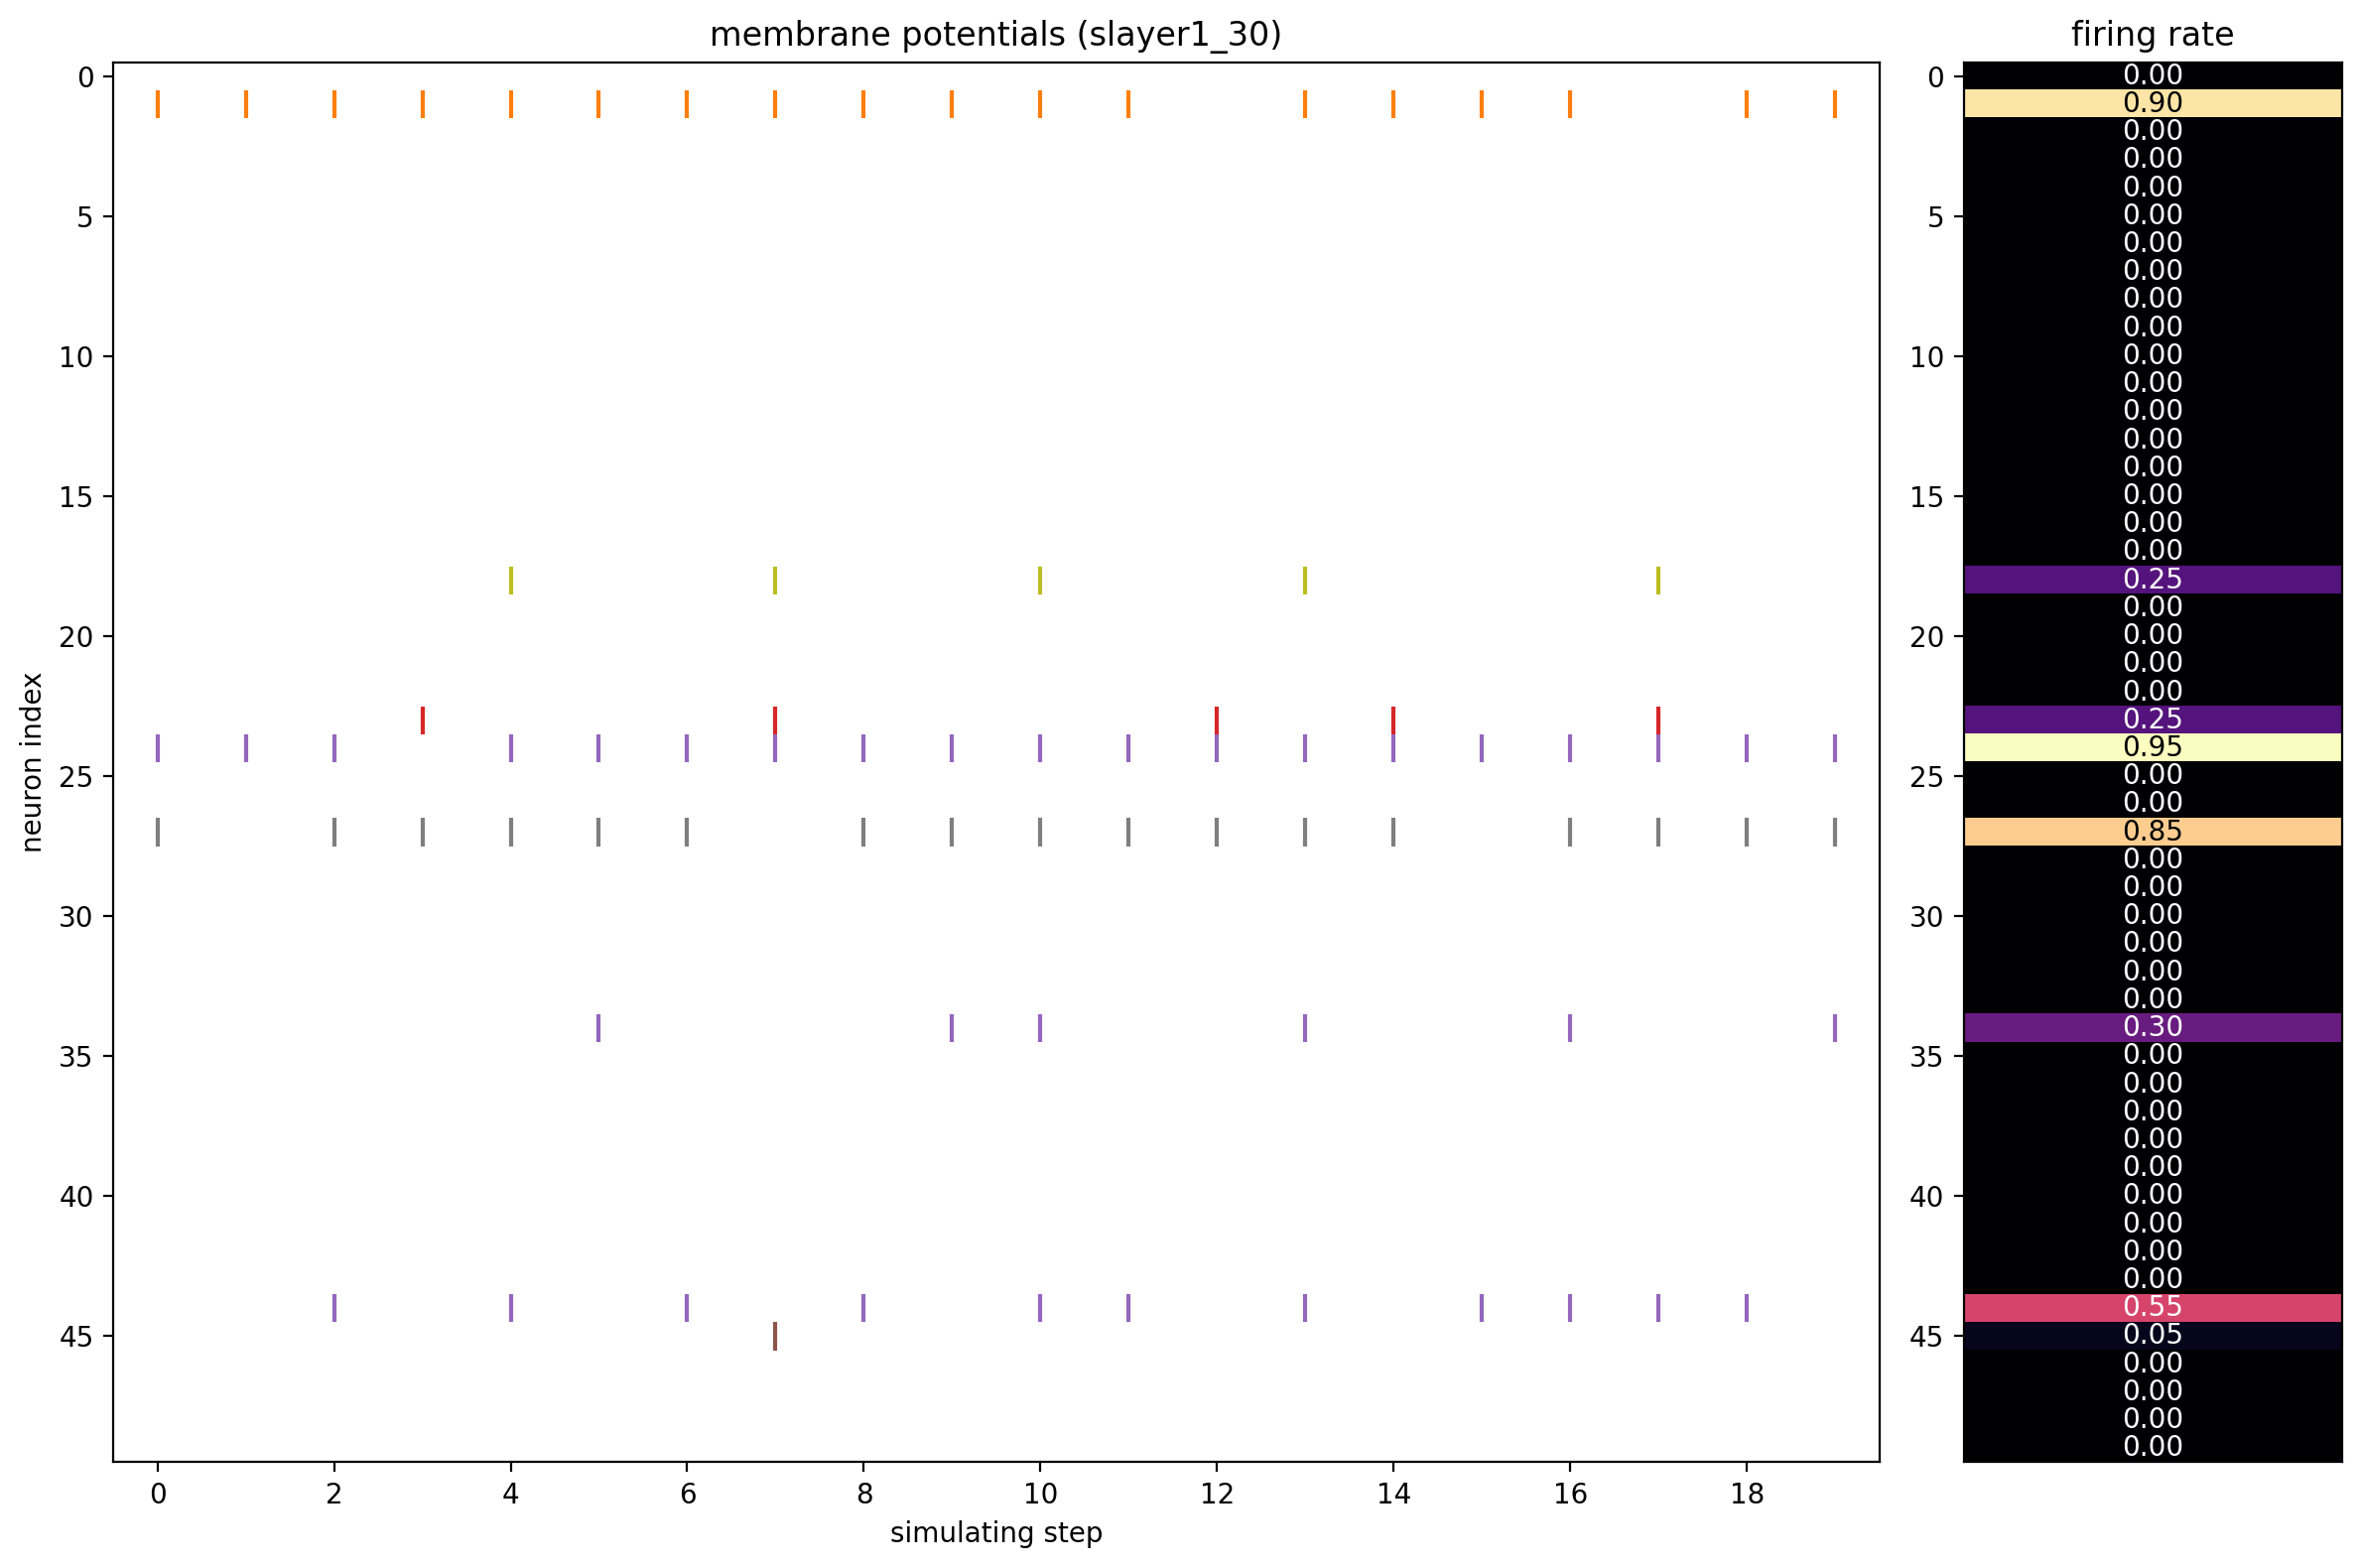

In [10]:
###### from spikingjelly import visualizing
import matplotlib.pyplot as plt
from spikingjelly import visualizing

figsize = (12, 8)
dpi = 200

# Define the indices of the layers you want to plot
layer_indices = [2 , 30]

# Iterate over the layer indices
for idx in layer_indices:
    # Extract the data for the current layer
    layer_data = last_epoch_record[0][idx]
    layer_data = layer_data.transpose(0, 1)
    
    # Plot the data
    visualizing.plot_1d_spikes(spikes=layer_data.detach().numpy(), title=f'membrane potentials (slayer1_{idx})', xlabel='simulating step',
                               ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

torch.Size([50, 784])